In [57]:
import pandas as pd
import ast
import json
import os
import re
import string
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from wordcloud import WordCloud

sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 120

### 1. SETUP PATH

In [58]:
# os.getcwd() di VSCode notebook = folder notebooks/, jadi naik 1 level
BASE_DIR = os.path.dirname(os.getcwd())
DATA_RAW_DIR = os.path.join(BASE_DIR, "data", "raw")
DATA_PROC_DIR = os.path.join(BASE_DIR, "data", "processed")

print(f"BASE_DIR: {BASE_DIR}")

BASE_DIR: d:\Kuliah\TA\Notebook


In [59]:
os.makedirs(DATA_PROC_DIR, exist_ok=True)

In [60]:
# Nama file
input_file_path = os.path.join(DATA_RAW_DIR, 'ABSA_all_2500data_train.txt')
slang_file_path = os.path.join(DATA_RAW_DIR, 'colloquial-indonesian-lexicon.csv')
output_json_path = os.path.join(DATA_PROC_DIR, 'train_data_bieos.json')

print(f"📂 Membaca data dari: {input_file_path}")
print(f"📂 Membaca data dari: {slang_file_path}")

📂 Membaca data dari: d:\Kuliah\TA\Notebook\data\raw\ABSA_all_2500data_train.txt
📂 Membaca data dari: d:\Kuliah\TA\Notebook\data\raw\colloquial-indonesian-lexicon.csv


### 2. EXPLORATORY DATA ANALYSIS (EDA)

In [61]:
# Parse raw data: setiap baris = "text####[(aspect_idx, opinion_idx, sentiment), ...]"
sentences = []
all_aspects = []

with open(input_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line or '####' not in line:
            continue
        text_part, label_part = line.split('####', 1)
        tokens = text_part.split()
        aspects = ast.literal_eval(label_part)
        
        sentiments = [a[2] for a in aspects]
        aspect_terms = [' '.join(tokens[i] for i in a[0] if i < len(tokens)) for a in aspects]
        
        sentences.append({
            'text': text_part,
            'tokens': tokens,
            'num_tokens': len(tokens),
            'aspects': aspects,
            'num_aspects': len(aspects),
            'sentiments': sentiments,
            'aspect_terms': aspect_terms,
        })
        all_aspects.extend([{'term': t, 'sentiment': s} for t, s in zip(aspect_terms, sentiments)])

df_sent = pd.DataFrame(sentences)
df_asp = pd.DataFrame(all_aspects)

print(f"Total kalimat : {len(df_sent)}")
print(f"Total aspek   : {len(df_asp)}")
print(f"\nContoh data:")
df_sent[['text', 'num_tokens', 'num_aspects', 'sentiments']].head()

Total kalimat : 2511
Total aspek   : 5973

Contoh data:


,text,num_tokens,num_aspects,sentiments
0,banyak hewan blekok nya,4,1,[NEU]
1,"ekowisata kampung blekok di dusun pesisir , de...",162,7,"[POS, POS, NEU, NEU, POS, NEU, POS]"
2,"selain terkenal akan mangrove , kampung blekok...",42,4,"[POS, POS, NEU, NEU]"
3,bagus jalannya tapi jauh,4,2,"[POS, NEG]"
4,50 desa wisata terbaik di indonesia,6,1,[NEU]


#### 2.1 Distribusi Label Sentimen

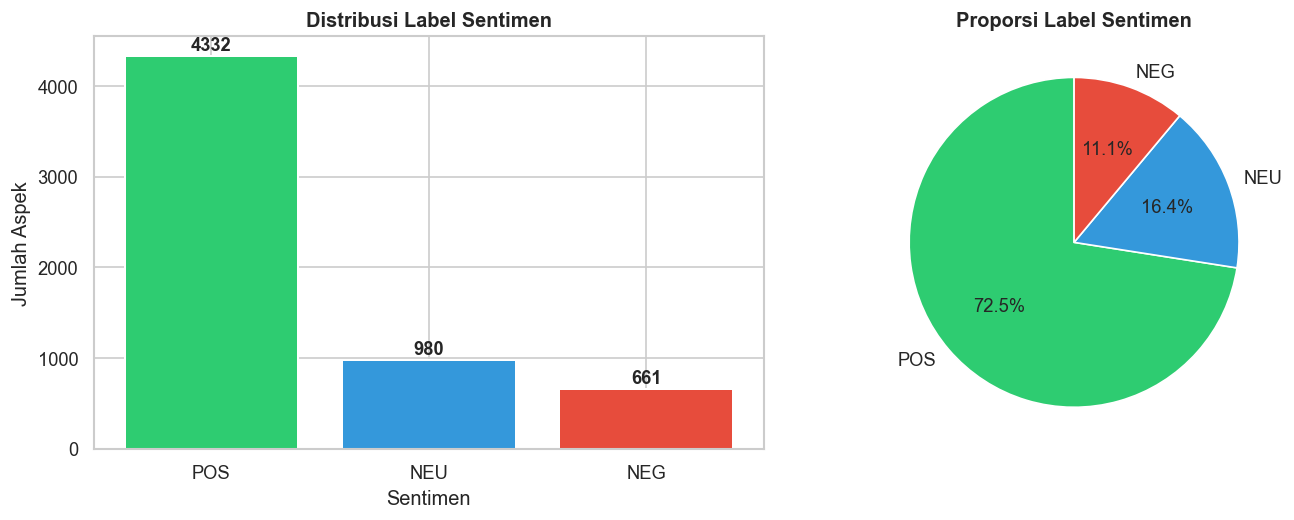


Rincian:
  POS: 4332 (72.5%)
  NEU: 980 (16.4%)
  NEG: 661 (11.1%)


In [62]:
sentiment_counts = df_asp['sentiment'].value_counts()
colors = {'POS': '#2ecc71', 'NEG': '#e74c3c', 'NEU': '#3498db'}

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Bar chart
bars = axes[0].bar(sentiment_counts.index, sentiment_counts.values,
                   color=[colors[s] for s in sentiment_counts.index], edgecolor='white', linewidth=1.2)
for bar, val in zip(bars, sentiment_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 15,
                 str(val), ha='center', va='bottom', fontweight='bold', fontsize=11)
axes[0].set_title('Distribusi Label Sentimen', fontweight='bold')
axes[0].set_ylabel('Jumlah Aspek')
axes[0].set_xlabel('Sentimen')

# Pie chart
axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index,
            colors=[colors[s] for s in sentiment_counts.index],
            autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11})
axes[1].set_title('Proporsi Label Sentimen', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nRincian:")
for s, c in sentiment_counts.items():
    print(f"  {s}: {c} ({c/len(df_asp)*100:.1f}%)")

#### 2.2 Distribusi Panjang Sequence (Token Count)

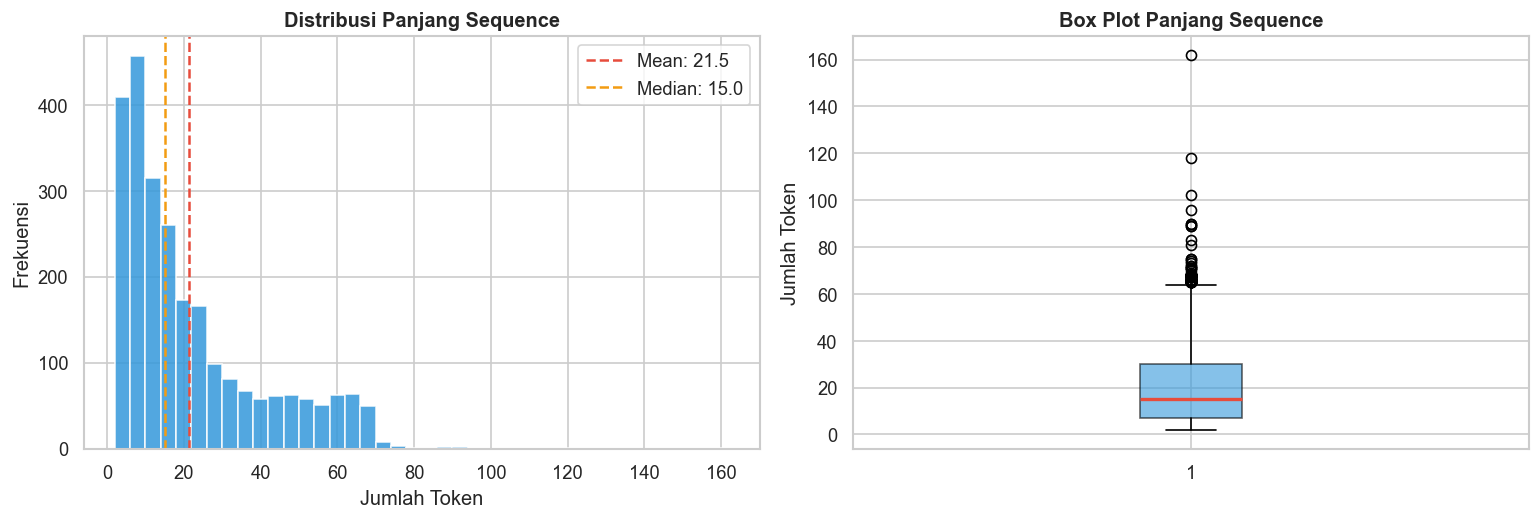

Statistik Panjang Sequence:
  Min    : 2
  Max    : 162
  Mean   : 21.5
  Median : 15
  Std    : 18.8
  Q1     : 7
  Q3     : 30


In [63]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

# Histogram
axes[0].hist(df_sent['num_tokens'], bins=40, color='#3498db', edgecolor='white', alpha=0.85)
axes[0].axvline(df_sent['num_tokens'].mean(), color='#e74c3c', linestyle='--', linewidth=1.5, label=f"Mean: {df_sent['num_tokens'].mean():.1f}")
axes[0].axvline(df_sent['num_tokens'].median(), color='#f39c12', linestyle='--', linewidth=1.5, label=f"Median: {df_sent['num_tokens'].median():.1f}")
axes[0].set_title('Distribusi Panjang Sequence', fontweight='bold')
axes[0].set_xlabel('Jumlah Token')
axes[0].set_ylabel('Frekuensi')
axes[0].legend()

# Box plot
axes[1].boxplot(df_sent['num_tokens'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='#3498db', alpha=0.6),
                medianprops=dict(color='#e74c3c', linewidth=2))
axes[1].set_title('Box Plot Panjang Sequence', fontweight='bold')
axes[1].set_ylabel('Jumlah Token')

plt.tight_layout()
plt.show()

stats = df_sent['num_tokens'].describe()
print(f"Statistik Panjang Sequence:")
print(f"  Min    : {stats['min']:.0f}")
print(f"  Max    : {stats['max']:.0f}")
print(f"  Mean   : {stats['mean']:.1f}")
print(f"  Median : {stats['50%']:.0f}")
print(f"  Std    : {stats['std']:.1f}")
print(f"  Q1     : {stats['25%']:.0f}")
print(f"  Q3     : {stats['75%']:.0f}")

#### 2.3 Aspect Density (Jumlah Aspek per Kalimat)

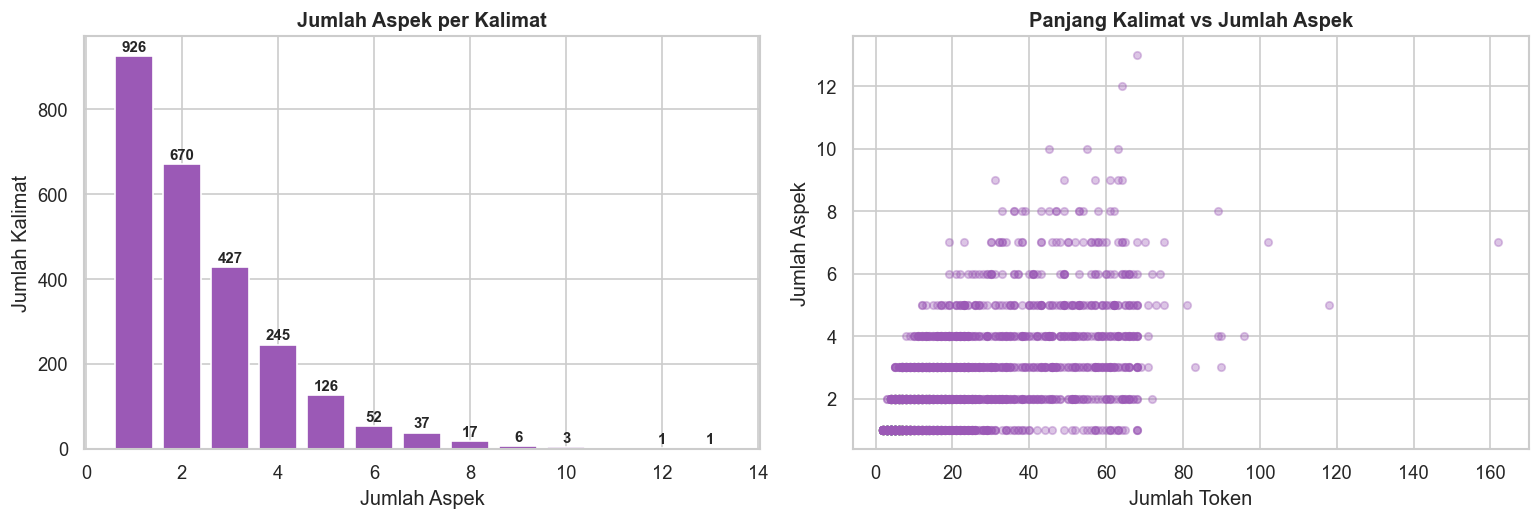

Statistik Aspek per Kalimat:
  Mean   : 2.38
  Median : 2
  Max    : 13
  Kalimat dengan 1 aspek  : 926 (36.9%)
  Kalimat dengan >3 aspek : 488 (19.4%)


In [64]:
aspect_counts = df_sent['num_aspects'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

# Bar chart jumlah aspek per kalimat
bars = axes[0].bar(aspect_counts.index, aspect_counts.values, color='#9b59b6', edgecolor='white')
for bar, val in zip(bars, aspect_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 str(val), ha='center', va='bottom', fontsize=9, fontweight='bold')
axes[0].set_title('Jumlah Aspek per Kalimat', fontweight='bold')
axes[0].set_xlabel('Jumlah Aspek')
axes[0].set_ylabel('Jumlah Kalimat')
axes[0].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Scatter: panjang kalimat vs jumlah aspek
axes[1].scatter(df_sent['num_tokens'], df_sent['num_aspects'], alpha=0.35, s=20, color='#9b59b6')
axes[1].set_title('Panjang Kalimat vs Jumlah Aspek', fontweight='bold')
axes[1].set_xlabel('Jumlah Token')
axes[1].set_ylabel('Jumlah Aspek')

plt.tight_layout()
plt.show()

print(f"Statistik Aspek per Kalimat:")
print(f"  Mean   : {df_sent['num_aspects'].mean():.2f}")
print(f"  Median : {df_sent['num_aspects'].median():.0f}")
print(f"  Max    : {df_sent['num_aspects'].max()}")
print(f"  Kalimat dengan 1 aspek  : {(df_sent['num_aspects'] == 1).sum()} ({(df_sent['num_aspects'] == 1).mean()*100:.1f}%)")
print(f"  Kalimat dengan >3 aspek : {(df_sent['num_aspects'] > 3).sum()} ({(df_sent['num_aspects'] > 3).mean()*100:.1f}%)")

#### 2.4 Noise Analysis

C:\Users\jason\AppData\Local\Temp\ipykernel_31272\184006626.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  'Elongasi (aaa, iii)': texts.str.contains(r'(.)\1{2,}', regex=True).sum(),


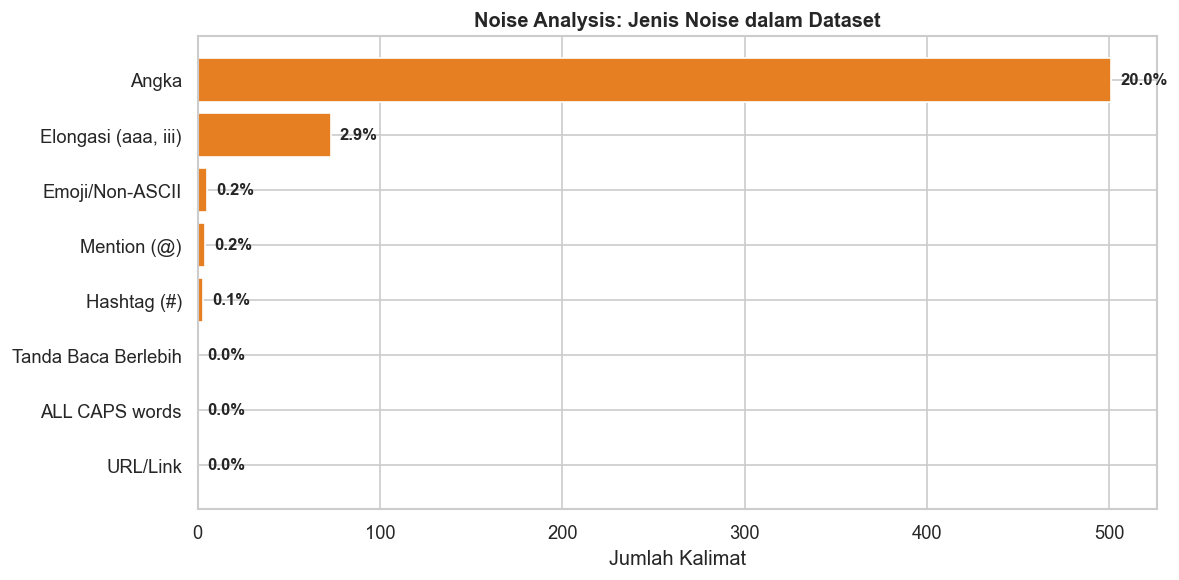

        Jenis Noise  Jumlah Kalimat  Persentase
              Angka             501        20.0
Elongasi (aaa, iii)              73         2.9
    Emoji/Non-ASCII               5         0.2
        Mention (@)               4         0.2
        Hashtag (#)               3         0.1
Tanda Baca Berlebih               0         0.0
           URL/Link               0         0.0
     ALL CAPS words               0         0.0


In [65]:
# Deteksi berbagai jenis noise dalam teks
texts = df_sent['text']

noise = {
    'URL/Link': texts.str.contains(r'https?://\S+|www\.\S+', regex=True).sum(),
    'Mention (@)': texts.str.contains(r'@\w+', regex=True).sum(),
    'Hashtag (#)': texts.str.contains(r'#\w+', regex=True).sum(),
    'Emoji/Non-ASCII': texts.str.contains(r'[^\x00-\x7F]', regex=True).sum(),
    'Angka': texts.str.contains(r'\d+', regex=True).sum(),
    'Elongasi (aaa, iii)': texts.str.contains(r'(.)\1{2,}', regex=True).sum(),
    'Tanda Baca Berlebih': texts.str.contains(r'[!?]{2,}|\.{3,}', regex=True).sum(),
    'ALL CAPS words': texts.apply(lambda x: any(w.isupper() and len(w) > 1 for w in x.split())).sum(),
}

noise_df = pd.DataFrame(list(noise.items()), columns=['Jenis Noise', 'Jumlah Kalimat'])
noise_df['Persentase'] = (noise_df['Jumlah Kalimat'] / len(df_sent) * 100).round(1)
noise_df = noise_df.sort_values('Jumlah Kalimat', ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(noise_df['Jenis Noise'], noise_df['Jumlah Kalimat'], color='#e67e22', edgecolor='white')
for bar, pct in zip(bars, noise_df['Persentase']):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
            f'{pct}%', va='center', fontsize=10, fontweight='bold')
ax.set_title('Noise Analysis: Jenis Noise dalam Dataset', fontweight='bold')
ax.set_xlabel('Jumlah Kalimat')
plt.tight_layout()
plt.show()

print(noise_df.sort_values('Jumlah Kalimat', ascending=False).to_string(index=False))

#### 2.5 Word Cloud

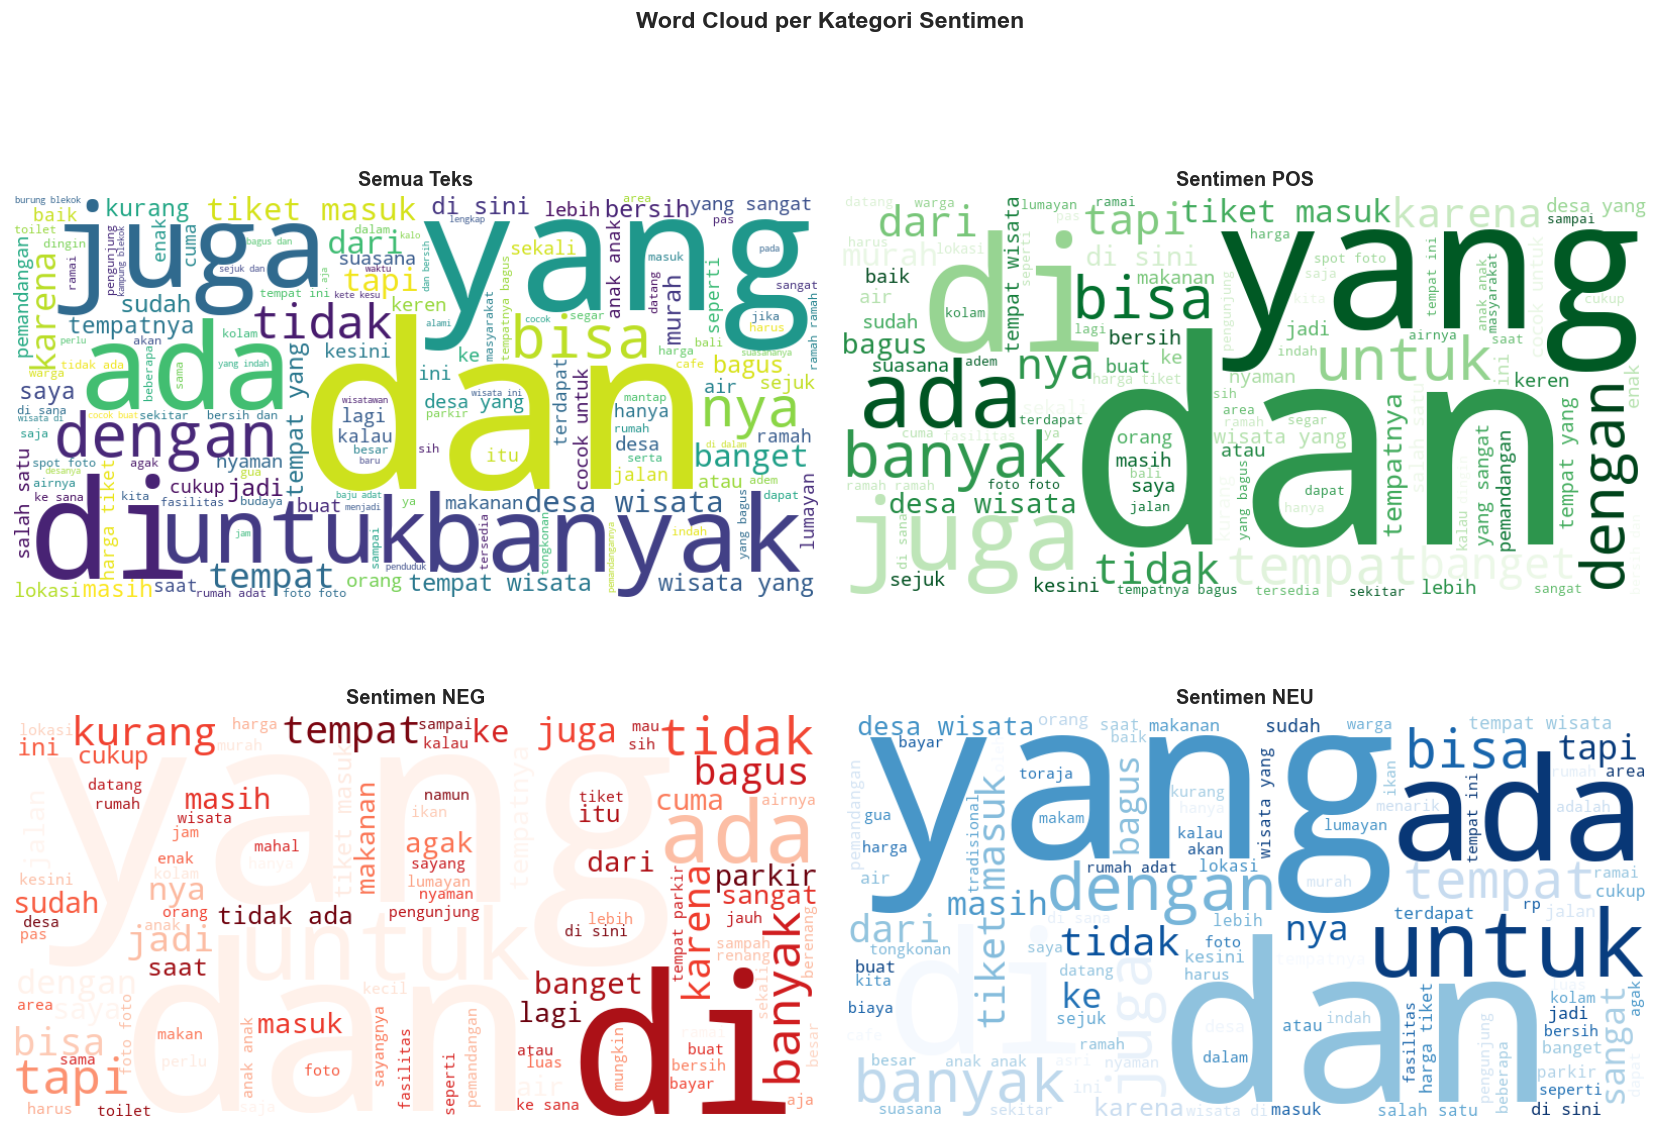

In [66]:
# Word cloud untuk keseluruhan teks dan per sentimen
all_text = ' '.join(df_sent['text'])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Word cloud keseluruhan
wc_all = WordCloud(width=800, height=400, background_color='white',
                   colormap='viridis', max_words=150).generate(all_text)
axes[0, 0].imshow(wc_all, interpolation='bilinear')
axes[0, 0].set_title('Semua Teks', fontweight='bold', fontsize=12)
axes[0, 0].axis('off')

# Word cloud per sentimen
sentiment_config = [
    ('POS', '#2ecc71', 'Greens', axes[0, 1]),
    ('NEG', '#e74c3c', 'Reds', axes[1, 0]),
    ('NEU', '#3498db', 'Blues', axes[1, 1]),
]

for sent, color, cmap, ax in sentiment_config:
    # Gabungkan teks dari kalimat yang mengandung sentimen ini
    mask = df_sent['sentiments'].apply(lambda s: sent in s)
    text = ' '.join(df_sent.loc[mask, 'text'])
    if text.strip():
        wc = WordCloud(width=800, height=400, background_color='white',
                       colormap=cmap, max_words=100).generate(text)
        ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'Sentimen {sent}', fontweight='bold', fontsize=12)
    ax.axis('off')

plt.suptitle('Word Cloud per Kategori Sentimen', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 3. Load Slang Dictionary

In [67]:
try:
    slang_df = pd.read_csv(slang_file_path)
    slang_dict = dict(zip(slang_df['slang'].str.lower(), slang_df['formal'].str.lower()))
    print("✅ Kamus gaul berhasil dimuat.")
except FileNotFoundError:
    print("⚠️ WARNING: File slang tidak ditemukan. Pastikan file ada di folder data/raw!")
    slang_dict = {}

✅ Kamus gaul berhasil dimuat.


### 4. Fungsi Konversi BIEOS + Normalisasi Slang

In [68]:
def convert_to_bioes_and_normalize(line, slang_map):
    if "####" not in line: return None

    try:
        text_part, label_part = line.split("####")
        words = text_part.strip().split()
        labels_info = ast.literal_eval(label_part.strip())
    except (ValueError, SyntaxError):
        return None

    # Inisialisasi label O
    bioes_labels = ["O"] * len(words)

    # Mapping ke BIEOS (hanya aspect, bukan opinion)
    for aspects, opinions, sentiment in labels_info:
        valid_aspects = [idx for idx in aspects if idx < len(words)]
        if not valid_aspects: continue

        valid_aspects.sort()
        if len(valid_aspects) == 1:
            bioes_labels[valid_aspects[0]] = f"S-{sentiment}"
        else:
            for i, idx in enumerate(valid_aspects):
                if i == 0: bioes_labels[idx] = f"B-{sentiment}"
                elif i == len(valid_aspects) - 1: bioes_labels[idx] = f"E-{sentiment}"
                else: bioes_labels[idx] = f"I-{sentiment}"

    # Normalisasi slang & re-alignment label
    final_words = []
    final_labels = []

    for word, label in zip(words, bioes_labels):
        word_clean = word.lower().strip(string.punctuation)

        if word_clean in slang_map and len(word_clean) > 1:
            formal_tokens = slang_map[word_clean].split()
            final_words.extend(formal_tokens)
            n = len(formal_tokens)

            if n == 1:
                final_labels.append(label)
            elif label == "O":
                final_labels.extend(["O"] * n)
            elif label.startswith("S-"):
                base = label.split("-", 1)[1]
                final_labels.append(f"B-{base}")
                final_labels.extend([f"I-{base}"] * (n - 2))
                final_labels.append(f"E-{base}")
            elif label.startswith("B-"):
                base = label.split("-", 1)[1]
                final_labels.append(f"B-{base}")
                final_labels.extend([f"I-{base}"] * (n - 1))
            elif label.startswith("E-"):
                base = label.split("-", 1)[1]
                final_labels.extend([f"I-{base}"] * (n - 1))
                final_labels.append(f"E-{base}")
            else:  # I-
                final_labels.extend([label] * n)
        else:
            final_words.append(word)
            final_labels.append(label)

    return {"tokens": final_words, "labels": final_labels}

### 5. Eksekusi Konversi

In [69]:
output_data = []

if os.path.exists(input_file_path):
    with open(input_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            processed = convert_to_bioes_and_normalize(line, slang_dict)
            if processed:
                output_data.append(processed)
    print(f"Total data setelah konversi: {len(output_data)}")
else:
    print(f"ERROR: File {input_file_path} tidak ditemukan.")

Total data setelah konversi: 2511


### 6. Penyaringan Ulasan Pendek

In [70]:
MIN_TOKENS = 3  # Minimum jumlah token agar ulasan tidak terlalu pendek

before_count = len(output_data)

# Filter: ulasan harus punya minimal MIN_TOKENS token
# dan minimal 1 label non-O (ada aspek yang di-tag)
filtered_data = [
    d for d in output_data
    if len(d['tokens']) >= MIN_TOKENS and any(l != 'O' for l in d['labels'])
]

removed = before_count - len(filtered_data)
print(f"Sebelum filter : {before_count}")
print(f"Sesudah filter : {len(filtered_data)}")
print(f"Dibuang        : {removed} ({removed/before_count*100:.1f}%)")

# Tampilkan contoh yang dibuang
removed_data = [d for d in output_data if d not in filtered_data]
if removed_data:
    print(f"\nContoh ulasan yang dibuang:")
    for d in removed_data[:5]:
        print(f"  tokens={d['tokens']}, labels={d['labels']}")

output_data = filtered_data

Sebelum filter : 2511
Sesudah filter : 2451
Dibuang        : 60 (2.4%)

Contoh ulasan yang dibuang:
  tokens=['wisata', 'baru'], labels=['S-NEU', 'O']
  tokens=['bagus', 'tempatnya'], labels=['O', 'S-POS']
  tokens=['liburan', 'murah'], labels=['S-POS', 'O']
  tokens=['tempatnya', 'keren'], labels=['S-POS', 'O']
  tokens=['tongkonan', 'bersejarah'], labels=['S-NEU', 'O']


### 7. Simpan Hasil & Verifikasi

In [71]:
# Simpan hasil
with open(output_json_path, 'w', encoding='utf-8') as f:
    json.dump(output_data, f, ensure_ascii=False, indent=4)

print(f"Hasil tersimpan di: {output_json_path}")
print(f"Total data final: {len(output_data)}")

# Verifikasi: pastikan semua tokens & labels panjangnya sama
mismatched = [i for i, d in enumerate(output_data) if len(d['tokens']) != len(d['labels'])]
if mismatched:
    print(f"\nWARNING: {len(mismatched)} data punya panjang tokens != labels!")
    for idx in mismatched[:3]:
        d = output_data[idx]
        print(f"  idx={idx}: tokens={len(d['tokens'])}, labels={len(d['labels'])}")
else:
    print("Semua data valid (panjang tokens == labels)")

# Statistik label
all_labels = [l for d in output_data for l in d['labels']]
label_counts = Counter(all_labels)
print(f"\nDistribusi label BIEOS:")
for label, count in sorted(label_counts.items()):
    print(f"  {label:8s}: {count}")

# Contoh hasil
print(f"\nContoh 3 data teratas:")
for d in output_data[:3]:
    print(f"  Tokens: {d['tokens']}")
    print(f"  Labels: {d['labels']}\n")

Hasil tersimpan di: d:\Kuliah\TA\Notebook\data\processed\train_data_bieos.json
Total data final: 2451
Semua data valid (panjang tokens == labels)

Distribusi label BIEOS:
  B-NEG   : 296
  B-NEU   : 551
  B-POS   : 1260
  E-NEG   : 296
  E-NEU   : 551
  E-POS   : 1260
  I-NEG   : 187
  I-NEU   : 293
  I-POS   : 731
  O       : 45358
  S-NEG   : 320
  S-NEU   : 349
  S-POS   : 2302

Contoh 3 data teratas:
  Tokens: ['banyak', 'hewan', 'blekok', 'nya']
  Labels: ['O', 'B-NEU', 'E-NEU', 'O']

  Tokens: ['ekowisata', 'kampung', 'blekok', 'di', 'dusun', 'pesisir', ',', 'desa', 'klatakan', ',', 'kecamatan', 'kendit', ',', 'situbondo', ',', 'jawa', 'timur', ',', 'sudah', 'menjadi', 'rujukan', 'wisatawan', '.', 'setiap', 'hari', ',', 'wisatawan', 'dari', 'berbagai', 'daerah', 'selalu', 'ramai', 'mengunjungi', 'destinasi', 'wisata', 'itu', '.', 'lokasi', 'wisata', 'ini', 'terletak', 'di', 'jalur', 'pantai', 'utara', '(', 'pantura', ')', ',', 'dekat', 'dari', 'pusat', 'kota', 'situbondo', ',', '